# Case Study: Modelling obesity for inhabitants of Utrecht by making use of ABM

In [1]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import numpy as np
import datetime
import math


from shapely.geometry import Polygon, Point

import pcraster.framework as pcrfw
import pcraster as pcr

from osgeo import gdal, ogr, osr

import lue.data_model as ldm

import campo

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Reading the datasets

Reading the dataset that contains the points with information such as BMI, annual income and distance to fast food outlet per househould

In [2]:
agents_per_district = pd.read_csv('agents_with_bmi_income.csv', sep = ',', header=None)

columns = {0: 'x', 1: 'y', 2: 'district', 3: 'duplicate', 4: 'BMI', 5: 'annual_income', 6: 'district_2', 7: 'increment_percentage', 8: 'minimum_distance'}
agents_per_district.rename(columns=columns, inplace=True)

agents_per_district.drop(['district_2'], inplace=True, axis=1)

# Divide the annual increment by 3 (because our timesteps are every three months)
agents_per_district['increment_percentage'] = agents_per_district['increment_percentage'].apply(lambda row: row/3)

display(agents_per_district)

,x,y,district,duplicate,BMI,annual_income,increment_percentage,minimum_distance
0,137137.600000,456000.500000,Binnenstad,False,22.957403,30543.108190,0.004333,125.1
1,135836.600000,455877.500000,Binnenstad,False,20.331292,36792.036340,0.004333,181.4
2,136756.998914,455242.500997,Binnenstad,False,19.951849,34648.935494,0.004333,145.3
3,136754.900000,456546.100000,Binnenstad,False,22.028415,29281.115858,0.004333,125.9
4,136634.100000,456232.900000,Binnenstad,False,23.104601,32064.199244,0.004333,13.5
...,...,...,...,...,...,...,...,...
17256,136000.500000,454697.400000,Zuidwest,False,26.271288,29359.515094,0.004222,377.4
17257,136250.800000,453965.500000,Zuidwest,False,30.096850,29003.975290,0.004222,133.0
17258,136337.300000,454676.700000,Zuidwest,False,25.705301,36652.941107,0.004222,224.6
17259,134468.300000,454543.000000,Zuidwest,False,32.098342,31048.584777,0.004222,518.3


Reading the dataset that contains the hyperapameters adjusted by calibration per neighbourhood

In [3]:
hyperparameters = pd.read_csv('district_k.csv', sep = ',')

# Delete columns that we're not going to use in the ABM model
hyperparameters = hyperparameters.drop(['Unnamed: 0', 'mae'], axis=1)

display(hyperparameters)

,k1,k2,k3,district
0,20,0.010,0.010,Binnenstad
1,10,0.005,0.005,Leidsche Rijn
2,15,0.010,0.005,Noordoost
3,5,0.005,0.005,Noordwest
4,15,0.005,0.020,Oost
5,20,0.005,0.005,Overvecht
6,15,0.010,0.010,West
7,15,0.005,0.015,Zuid
8,15,0.010,0.005,Zuidwest


In [4]:
# Set the calibrated hyperparameter to each household depending on the neighbourhood in which they are located
agents_per_district = agents_per_district.merge(hyperparameters, on='district')

## ABM model

This is the class that we are going to use to create our ABM enviornment

In [5]:
pcr.setrandomseed(123)

class FoodEnvironment(pcrfw.DynamicModel):
    def __init__(self):
        pcrfw.DynamicModel.__init__(self)
        # Framework requires a clone
        # set a dummy clone
        pcr.setclone(10, 20, 10, 0, 0)

    ##########################
    # Differential Equations #
    ##########################
    
    # Get probability that a household will visit a fast food outlet, given their distance from the outlet, income, and taxes applied.
    def get_exponential(self, distance, income, k1, k3):
        if self.current_step <= buffer:
            return 1 / (1 + campo.exp( ( - k1 * distance ) + ( k3 * income * (1 + 0 * k4) ) ) )
        else:
            return 1 / (1 + campo.exp( ( - k1 * distance ) + ( k3 * income * (1 + p * k4) ) ) )
    
    # This equation represents the change in BMI per unit time. 
    # The equation takes into account the effect of distance, the effect of time on the BMI and the probability that a household will visit a fast food.
    def diffEqBMI(self, bmi, income, distance, k1, k2, k3):
        return ( k1 * ( (1 / distance)  * self.get_exponential(distance, income, k1, k3) ) - (k2 * bmi))
    
    def diffEqIncome(self, percentage, income):
        return percentage * income

    def initial(self):
        init_start = datetime.datetime.now()
        
        self.current_step = 0
        
        self.foodenv = campo.Campo()

        ##############
        # Households #
        ##############

        # Create households phenomenon
        self.hh = self.foodenv.add_phenomenon('hh')
        self.hh.add_property_set('fd', 'new_agents.csv')

        # Set initial bmi of households
        bmi_values = agents_per_district["BMI"]
        self.hh.fd.bmi = bmi_values.to_numpy()
        
        # Set initial income of households
        income_values = agents_per_district["annual_income"]
        self.hh.fd.income = income_values.to_numpy()/3
        
        # Set distance to the nearest food outlet
        income_values = agents_per_district["minimum_distance"]
        self.hh.fd.min_distance = income_values.to_numpy()
        
        percentage_values = agents_per_district["increment_percentage"]
        self.hh.fd.increment_percentage = percentage_values.to_numpy()
        
        # Set hyperparameters
        k1 = agents_per_district["k1"]
        self.hh.fd.k1 = k1.to_numpy()
        
        k2 = agents_per_district["k2"]
        self.hh.fd.k2 = k2.to_numpy()
        
        k3 = agents_per_district["k3"]
        self.hh.fd.k3 = k3.to_numpy()
        
        # Technical detail: set map projection
        self.hh.set_epsg(28992)

        ##############
        # Foodstores #
        ##############

        # Create foodstores phenomenon
        self.fs = self.foodenv.add_phenomenon('fs')

        # Add the frontdoor property set
        self.fs.add_property_set('fd', 'new_agents_stores.csv')

        # Technical detail
        self.fs.set_epsg(28992)

        # Set the duration (years) of one time step
        self.timestep = 0.333333

        # Create the output lue data set
        self.foodenv.create_dataset("food_environment.lue")

        # Create real time settings for lue
        date = datetime.date(2000, 1, 2)
        time = datetime.time(12, 34)
        start = datetime.datetime.combine(date, time)
        unit = campo.TimeUnit.month
        stepsize = 4
        self.foodenv.set_time(start, unit, stepsize, self.nrTimeSteps())

        # Technical detail
        self.hh.fd.bmi.is_dynamic = True
        self.hh.fd.income.is_dynamic = True

        # Write the lue dataset
        self.foodenv.write()

        # print the run duration
        end = datetime.datetime.now() - init_start
        print(f'init: {end}')


    def dynamic(self):
        self.current_step += 1
        # update household income
        self.hh.fd.income = self.hh.fd.income + self.timestep * (self.diffEqIncome(self.hh.fd.increment_percentage, self.hh.fd.income))
        
        # update household propensity
        self.hh.fd.bmi = self.hh.fd.bmi + self.timestep * (self.diffEqBMI(self.hh.fd.bmi, self.hh.fd.income, self.hh.fd.min_distance, self.hh.fd.k1, self.hh.fd.k2, self.hh.fd.k3))
        
        self.hh.fd.over = 40
        self.hh.fd.bmi = campo.where(self.hh.fd.bmi < 40, self.hh.fd.bmi, self.hh.fd.over)
        
        self.hh.fd.under = 18
        self.hh.fd.bmi = campo.where(self.hh.fd.bmi > 18, self.hh.fd.bmi, self.hh.fd.under)
        
        # print run duration info
        self.foodenv.write(self.currentTimeStep())

In [6]:
def get_abm_model(n_timesteps, k4, p, filename):
    if __name__ == '__main__':
        timesteps = n_timesteps
        myModel = FoodEnvironment()
        dynFrw = pcrfw.DynamicFramework(myModel, timesteps)
        dynFrw.run()
    
    # Export infomation to gpkg files so we can visualise our data in QGIS
    dataset = ldm.open_dataset('food_environment.lue')

    for i in range(1, n_timesteps + 1):
        dataframe = campo.dataframe.select(dataset.hh, property_names=['bmi','income'])
        campo.to_gpkg(dataframe, 'households_{}.gpkg'.format(filename), 'EPSG:28992', i)
    
    dataframe = campo.dataframe.select(dataset.hh, property_names=['bmi', 'income'])
    campo.to_csv(dataframe, 'households_{}.csv'.format(filename))
    
    pd.pandas.set_option('display.max_columns', None)

    #Getting agents district from the outpiut
    df_bmi_hh = pd.read_csv('households_{}_bmi.csv'.format(filename))
    df_bmi_loc = pd.read_csv('households_{}_coords.csv'.format(filename))

    #Joining to get district of each household
    res = df_bmi_loc.merge(agents_per_district, how='inner', left_on=['CoordX', 'CoordY'], right_on=['x', 'y'])
    res.reset_index(inplace = True, drop = True)
    bmi_T = df_bmi_hh.T.reset_index()
    
    #df_bmi_hh.T
    resu = pd.concat([res, bmi_T], axis = 1)
    resu.drop(["CoordX", "CoordY", "duplicate"], inplace = True, axis = 1)

    # Measure error
    # Excluding gap points
    list_points_drop = [n for n in range(n_timesteps) if (n+1)%3 != 0 and n != 0]
    resu.drop(list_points_drop, inplace = True, axis = 1)

    # Start checking overweight
    resu.loc[resu["BMI"] >= 25  ,  "0_over"] = 1
    resu.loc[resu["BMI"] < 25  ,  "0_over"] = 0

    for n in range(n_timesteps):
        if (n+1)%3 == 0:
            resu.loc[resu[n] >= 25, "{}_over".format(n)] = 1
            resu.loc[resu[n] < 25 , "{}_over".format(n)] = 0

    # Groupby district average
    resu_2 = resu.groupby("district").mean().reset_index()

    # Reading real data
    real = pd.read_csv("overweight_data.csv" ,sep = ';')
    new_columns = {"overgewicht (inclusief obesitas), 18+ jaar|2012": "overgewicht_0",
                   "overgewicht (inclusief obesitas), 18+ jaar|2014": "overgewicht_5",
                   "overgewicht (inclusief obesitas), 18+ jaar|2016": "overgewicht_11",
                   "overgewicht (inclusief obesitas), 18+ jaar|2018": "overgewicht_17",
                   "overgewicht (inclusief obesitas), 18+ jaar|2020": "overgewicht_23"}
    real.rename(columns = new_columns, inplace = True)

    # Combinining to compare
    comb = resu_2.merge(real, right_on= "Wijken", left_on ="district", how = "inner" )
    comb.drop("Wijken", inplace = True, axis = 1)

    # Calculating mae for each year
    for n in range(n_timesteps):
        if (n+1)%3 == 0 or n == 0:
            comb["{}_over".format(n)] = (comb["{}_over".format(n)]*100).round(2)


    for n in range(24):
        if (n+1)%6 == 0 or n == 0:
            comb["{}_error".format(n)] = abs(comb["{}_over".format(n)] - comb["overgewicht_{}".format(n)])
        
    comb["avg_error"] = (comb["5_error"] + comb["11_error"] + comb["17_error"] + comb["23_error"])/4

    print("MAE=" , comb.avg_error.mean()) 
    return resu, comb

Function to plot the BMI of each agent

In [7]:
def get_plot(df):
    col_names = [n for n in range(n_timesteps) if (n+1)%3 == 0 or n == 0]
    district = df.district.unique()

    N = len(district)
    cols = 3
    rows = int(math.ceil(N / cols))

    x = [n for n in col_names]
    labels = [2012 + n for n in range(len(col_names))]

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure()

    for idx, name in enumerate(district):
        ax = fig.add_subplot(gs[idx])
        agents = agents_notaxes[agents_notaxes.district == name][col_names]
    
        for index, row in agents.iterrows():
            # Plotting the curves simultaneously
            ax.plot(row)
    
        ax.set_xticks(x, labels=labels, fontsize=5, rotation = 90)
        ax.axis(ymin=15, ymax=50)
        ax.set_title(name)
        ax.axvline(x = 9, linestyle='dotted')
    

    handles, labels = ax.get_legend_handles_labels()

    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))
    fig.tight_layout()

Getting the results for the scenario in which there's no increment in taxes

init: 0:00:03.866433
....................................................................................MAE= 2.730833333333334


,district,x,y,BMI,annual_income,increment_percentage,minimum_distance,k1,k2,k3,0,2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,0_over,2_over,5_over,8_over,11_over,14_over,17_over,20_over,23_over,26_over,29_over,32_over,35_over,38_over,41_over,44_over,47_over,50_over,53_over,56_over,59_over,62_over,65_over,68_over,71_over,74_over,77_over,80_over,83_over,overgewicht_0,overgewicht_5,overgewicht_11,overgewicht_17,overgewicht_23,0_error,5_error,11_error,17_error,23_error,avg_error
0,Binnenstad,136572.955513,455724.856612,23.709970,33674.195863,0.004333,161.886924,20.0,0.010,0.010,23.719194,23.737354,23.763890,23.789614,23.814594,23.837906,23.857704,23.872227,23.884123,23.893383,23.900943,23.905343,23.908935,23.911367,23.914435,23.916016,23.916135,23.915778,23.915023,23.911310,23.906509,23.900945,23.895272,23.888883,23.882520,23.874949,23.866461,23.857959,23.848466,24.93,25.12,26.25,27.00,27.28,28.03,28.60,29.35,30.01,30.29,30.95,31.51,31.80,32.27,33.02,32.83,32.55,33.21,33.58,33.77,33.96,33.58,33.40,33.68,33.68,33.77,33.58,33.87,33.58,25,23,22,32,25,0.07,3.25,5.28,3.40,5.01,4.2350
1,Leidsche Rijn,132264.023491,456324.491541,25.154885,41059.415027,0.004444,478.112256,10.0,0.005,0.005,25.125750,25.067628,24.980806,24.894418,24.808461,24.722934,24.637833,24.553191,24.469186,24.385965,24.303656,24.222253,24.141405,24.061209,23.981707,23.902964,23.825050,23.747778,23.671219,23.595276,23.519952,23.445285,23.370974,23.297331,23.224414,23.152350,23.081006,23.010361,22.940273,41.98,41.50,40.91,40.56,40.20,39.96,39.43,38.84,38.19,37.95,37.83,37.66,36.94,36.29,35.76,35.58,35.23,34.46,34.10,33.63,33.39,33.21,33.10,32.80,32.03,31.62,31.08,30.55,30.20,42,41,40,39,42,0.02,0.09,0.20,0.43,3.81,1.1325
2,Noordoost,137370.393420,457204.025609,24.250221,39697.077580,0.003889,280.527304,15.0,0.010,0.005,24.205243,24.115735,23.982587,23.850765,23.720457,23.591705,23.465435,23.341608,23.220122,23.100448,22.982960,22.868159,22.755678,22.645211,22.537185,22.431711,22.328380,22.227601,22.129258,22.033147,21.939734,21.848563,21.759641,21.672921,21.588560,21.506488,21.426642,21.348897,21.272909,30.98,30.20,29.77,29.73,29.47,28.95,28.39,28.21,27.95,27.65,27.35,27.04,26.57,26.22,25.75,25.36,24.75,24.02,23.32,22.59,22.07,21.55,21.03,20.68,20.03,19.52,19.04,18.39,17.87,31,32,35,30,27,0.02,2.23,5.53,1.61,0.95,2.5800
3,Noordwest,134926.464749,457776.462077,24.976559,28402.306832,0.005000,215.274684,5.0,0.005,0.005,24.948646,24.892960,24.809774,24.726999,24.644632,24.562669,24.481107,24.399969,24.319344,24.239327,24.159964,24.081189,24.003151,23.925839,23.849471,23.773858,23.699015,23.624879,23.551420,23.478823,23.407092,23.336056,23.265582,23.195774,23.126615,23.058065,22.990286,22.923254,22.856886,39.97,39.59,39.01,38.47,38.13,37.82,37.36,37.05,36.90,36.48,36.13,35.75,35.33,34.94,34.60,34.41,34.02,33.49,33.06,32.87,32.60,32.11,31.65,31.19,30.84,30.34,29.92,29.73,29.27,40,38,37,32,39,0.03,1.01,1.13,5.36,2.10,2.4000
4,Oost,138159.682065,455256.538657,23.707110,38852.051627,0.004333,282.208449,15.0,0.005,0.020,23.702617,23.693639,23.680196,23.666759,23.653262,23.639631,23.625809,23.611826,23.597774,23.583808,23.569922,23.556178,23.542386,23.528435,23.514596,23.500954,23.487459,23.474049,23.460690,23.447420,23.434058,23.420544,23.406765,23.392778,23.378675,23.364570,23.350417,23.336160,23.322023,23.96,24.21,24.42,24.68,24.94,25.30,25.50,25.71,25.81,26.12,26.53,26.89,27.00,27.05,27.00,27.05,27.10,27.15,27.41,27.36,27.46,27.67,27.87,28.03,28.03,27.98,27.82,27.72,27.61,24,24,19,24,24,0.04,0.42,5.94,1.50,1.81,2.4175
5,Overvecht,136113.384544,458881.635613,25.687894,25555.612266,0.003889,455.112841,20.0,0.005,0.005,25.673515,25.644780,25.601733,25.558738,25.512431,25.461097,25.409256,25.357674,25.306364,25.255383,25.204555,25.153941,25.103643,25.053826,25.004328,24.954884,24.905208,24.855763,24.806850,24.758414,24.710474,24.662870,24.615186,24.567641,24.520430,24.473525,24.427008,24.380866,24.334947,47.98,47.62,47.52,47.22,47.12,46.97,46.8

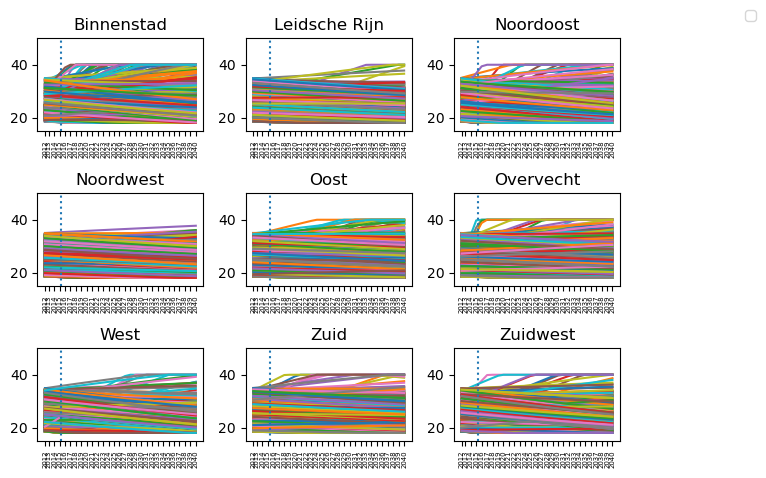

In [8]:
# Set information about taxes
n_timesteps, k4, p, buffer, filename = 84, 30, 0, 24, 'notaxes'
agents_notaxes, notaxes = get_abm_model(n_timesteps, k4, p, filename)
display(notaxes)
get_plot(agents_notaxes)

Getting the results for the scenario in which there's an increment of 10% in taxes

init: 0:00:03.905402
....................................................................................MAE= 2.730833333333334


,district,x,y,BMI,annual_income,increment_percentage,minimum_distance,k1,k2,k3,0,2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,0_over,2_over,5_over,8_over,11_over,14_over,17_over,20_over,23_over,26_over,29_over,32_over,35_over,38_over,41_over,44_over,47_over,50_over,53_over,56_over,59_over,62_over,65_over,68_over,71_over,74_over,77_over,80_over,83_over,overgewicht_0,overgewicht_5,overgewicht_11,overgewicht_17,overgewicht_23,0_error,5_error,11_error,17_error,23_error,avg_error
0,Binnenstad,136572.955513,455724.856612,23.709970,33674.195863,0.004333,161.886924,20.0,0.010,0.010,23.719194,23.737354,23.763890,23.789614,23.814594,23.837906,23.857704,23.872227,23.884123,23.844538,23.805500,23.766704,23.728741,23.691657,23.655567,23.620211,23.585284,23.551450,23.519010,23.487308,23.456145,23.425468,23.394966,23.363996,23.333852,23.304041,23.274334,23.245576,23.217554,24.93,25.12,26.25,27.00,27.28,28.03,28.60,29.35,30.01,30.10,30.76,31.23,31.42,31.89,32.64,32.36,32.08,32.64,32.83,32.93,33.11,32.64,32.46,32.55,32.36,32.17,31.70,31.98,31.61,25,23,22,32,25,0.07,3.25,5.28,3.40,5.01,4.2350
1,Leidsche Rijn,132264.023491,456324.491541,25.154885,41059.415027,0.004444,478.112256,10.0,0.005,0.005,25.125750,25.067628,24.980806,24.894418,24.808461,24.722934,24.637833,24.553191,24.469186,24.382339,24.296365,24.211286,24.126772,24.042926,23.959792,23.877434,23.795923,23.715070,23.634940,23.555414,23.476469,23.398149,23.320564,23.243684,23.167531,23.092209,23.017607,22.943726,22.870534,41.98,41.50,40.91,40.56,40.20,39.96,39.43,38.84,38.19,37.77,37.66,37.48,36.71,36.06,35.52,35.29,34.87,34.04,33.69,33.21,32.98,32.80,32.56,32.27,31.50,31.08,30.55,30.02,29.66,42,41,40,39,42,0.02,0.09,0.20,0.43,3.81,1.1325
2,Noordoost,137370.393420,457204.025609,24.250221,39697.077580,0.003889,280.527304,15.0,0.010,0.005,24.205243,24.115735,23.982587,23.850765,23.720457,23.591705,23.465435,23.341608,23.220122,23.093745,22.969656,22.848365,22.730054,22.614285,22.501002,22.390343,22.282316,22.176824,22.073771,21.973297,21.875611,21.780411,21.687605,21.597202,21.509103,21.423269,21.339667,21.258246,21.178844,30.98,30.20,29.77,29.73,29.47,28.95,28.39,28.21,27.95,27.61,27.30,26.91,26.40,26.05,25.53,25.14,24.49,23.71,23.02,22.28,21.77,21.25,20.73,20.38,19.73,19.21,18.69,18.04,17.52,31,32,35,30,27,0.02,2.23,5.53,1.61,0.95,2.5800
3,Noordwest,134926.464749,457776.462077,24.976559,28402.306832,0.005000,215.274684,5.0,0.005,0.005,24.948646,24.892960,24.809774,24.726999,24.644632,24.562669,24.481107,24.399969,24.319344,24.231374,24.144082,24.057407,23.971496,23.886335,23.802136,23.718701,23.636032,23.554054,23.472745,23.392290,23.312695,23.233809,23.155547,23.077982,23.001128,22.924873,22.849366,22.774589,22.700465,39.97,39.59,39.01,38.47,38.13,37.82,37.36,37.05,36.90,36.33,35.98,35.60,35.17,34.79,34.37,34.14,33.72,33.14,32.68,32.49,32.14,31.53,31.07,30.57,30.23,29.65,29.19,29.04,28.39,40,38,37,32,39,0.03,1.01,1.13,5.36,2.10,2.4000
4,Oost,138159.682065,455256.538657,23.707110,38852.051627,0.004333,282.208449,15.0,0.005,0.020,23.702617,23.693639,23.680196,23.666759,23.653262,23.639631,23.625809,23.611826,23.597774,23.549333,23.500927,23.452359,23.403576,23.354964,23.306705,23.258582,23.210488,23.162684,23.115102,23.067749,23.020387,22.973219,22.926282,22.879431,22.832925,22.786640,22.740616,22.694899,22.649328,23.96,24.21,24.42,24.68,24.94,25.30,25.50,25.71,25.81,25.61,25.30,25.14,24.78,24.42,24.01,23.96,23.75,23.70,23.54,23.29,23.24,23.18,23.08,22.87,22.57,22.41,22.10,21.79,21.48,24,24,19,24,24,0.04,0.42,5.94,1.50,1.81,2.4175
5,Overvecht,136113.384544,458881.635613,25.687894,25555.612266,0.003889,455.112841,20.0,0.005,0.005,25.673515,25.644780,25.601733,25.558738,25.512431,25.461097,25.409256,25.357674,25.306364,25.254979,25.203750,25.152735,25.102040,25.051827,25.001935,24.952100,24.902033,24.852201,24.802901,24.754081,24.705760,24.657776,24.609713,24.561791,24.514206,24.466928,24.420042,24.373546,24.327290,47.98,47.62,47.52,47.22,47.12,46.97,46.8

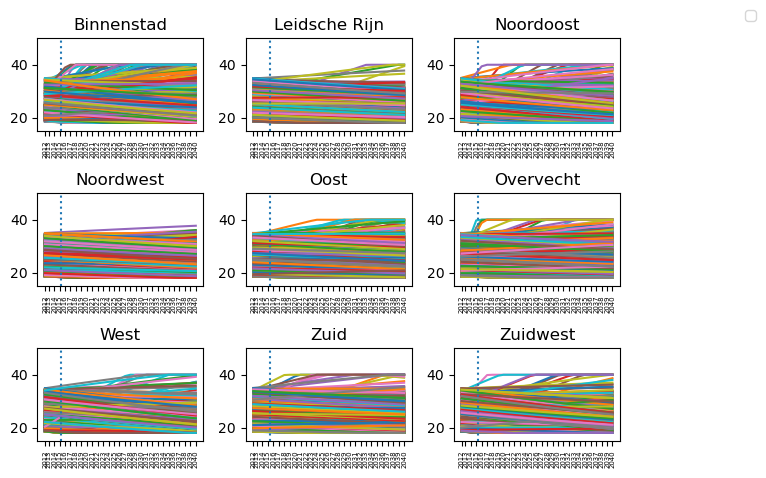

In [9]:
# Set information about taxes
n_timesteps, k4, p, buffer, filename = 84, 30, 0.1, 24, '10taxes'
agents_tentaxes, tentaxes = get_abm_model(n_timesteps, k4, p, filename)
display(tentaxes)
get_plot(agents_tentaxes)

Getting the results for the scenario in which there's an increment of 20% in taxes

init: 0:00:03.849467
....................................................................................MAE= 2.730833333333334


,district,x,y,BMI,annual_income,increment_percentage,minimum_distance,k1,k2,k3,0,2,5,8,11,14,17,20,23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,0_over,2_over,5_over,8_over,11_over,14_over,17_over,20_over,23_over,26_over,29_over,32_over,35_over,38_over,41_over,44_over,47_over,50_over,53_over,56_over,59_over,62_over,65_over,68_over,71_over,74_over,77_over,80_over,83_over,overgewicht_0,overgewicht_5,overgewicht_11,overgewicht_17,overgewicht_23,0_error,5_error,11_error,17_error,23_error,avg_error
0,Binnenstad,136572.955513,455724.856612,23.709970,33674.195863,0.004333,161.886924,20.0,0.010,0.010,23.719194,23.737354,23.763890,23.789614,23.814594,23.837906,23.857704,23.872227,23.884123,23.793114,23.703273,23.613976,23.525396,23.438106,23.352246,23.267848,23.184986,23.103985,23.024642,22.946177,22.868364,22.791356,22.715238,22.639879,22.566103,22.493192,22.421202,22.351148,22.282482,24.93,25.12,26.25,27.00,27.28,28.03,28.60,29.35,30.01,29.63,29.44,29.26,28.69,28.41,28.60,27.94,27.19,27.38,26.90,26.62,26.72,26.25,25.96,25.78,25.59,25.40,24.84,25.12,24.55,25,23,22,32,25,0.07,3.25,5.28,3.40,5.01,4.2350
1,Leidsche Rijn,132264.023491,456324.491541,25.154885,41059.415027,0.004444,478.112256,10.0,0.005,0.005,25.125750,25.067628,24.980806,24.894418,24.808461,24.722934,24.637833,24.553191,24.469186,24.378810,24.289383,24.200896,24.113001,24.025791,23.939312,23.853626,23.768804,23.684656,23.601244,23.518434,23.436232,23.354692,23.273844,23.193634,23.114153,23.035531,22.957661,22.880592,22.804296,41.98,41.50,40.91,40.56,40.20,39.96,39.43,38.84,38.19,37.77,37.60,37.30,36.41,35.70,35.17,34.87,34.46,33.69,33.33,32.80,32.56,32.21,31.97,31.56,30.73,30.31,29.78,29.19,28.83,42,41,40,39,42,0.02,0.09,0.20,0.43,3.81,1.1325
2,Noordoost,137370.393420,457204.025609,24.250221,39697.077580,0.003889,280.527304,15.0,0.010,0.005,24.205243,24.115735,23.982587,23.850765,23.720457,23.591705,23.465435,23.341608,23.220122,23.082855,22.947995,22.816064,22.687238,22.561064,22.437463,22.316529,22.198296,22.082745,21.969820,21.859649,21.752405,21.647770,21.545659,21.446086,21.348981,21.254378,21.162056,21.071867,20.983830,30.98,30.20,29.77,29.73,29.47,28.95,28.39,28.21,27.95,27.35,26.91,26.53,25.88,25.40,24.75,24.19,23.41,22.63,21.90,21.12,20.55,20.03,19.47,19.04,18.39,17.87,17.31,16.62,15.92,31,32,35,30,27,0.02,2.23,5.53,1.61,0.95,2.5800
3,Noordwest,134926.464749,457776.462077,24.976559,28402.306832,0.005000,215.274684,5.0,0.005,0.005,24.948646,24.892960,24.809774,24.726999,24.644632,24.562669,24.481107,24.399969,24.319344,24.223205,24.127760,24.032919,23.938852,23.845596,23.753337,23.661943,23.571271,23.481288,23.392080,23.303861,23.216728,23.130506,23.045009,22.960332,22.876421,22.793177,22.710787,22.629227,22.548381,39.97,39.59,39.01,38.47,38.13,37.82,37.36,37.05,36.90,36.33,35.98,35.56,35.02,34.64,34.14,33.91,33.49,32.91,32.30,32.11,31.72,30.96,30.53,29.96,29.61,28.92,28.39,28.15,27.54,40,38,37,32,39,0.03,1.01,1.13,5.36,2.10,2.4000
4,Oost,138159.682065,455256.538657,23.707110,38852.051627,0.004333,282.208449,15.0,0.005,0.020,23.702617,23.693639,23.680196,23.666759,23.653262,23.639631,23.625809,23.611826,23.597774,23.525025,23.452350,23.380035,23.308015,23.236295,23.164890,23.093866,23.023135,22.952774,22.882778,22.813487,22.744738,22.676389,22.608551,22.541114,22.474043,22.407431,22.341433,22.275892,22.210629,23.96,24.21,24.42,24.68,24.94,25.30,25.50,25.71,25.81,25.55,24.94,24.73,24.21,23.70,23.18,23.03,22.77,22.51,22.36,22.00,21.90,21.69,21.38,20.97,20.66,20.40,20.04,19.73,19.32,24,24,19,24,24,0.04,0.42,5.94,1.50,1.81,2.4175
5,Overvecht,136113.384544,458881.635613,25.687894,25555.612266,0.003889,455.112841,20.0,0.005,0.005,25.673515,25.644780,25.601733,25.558738,25.512431,25.461097,25.409256,25.357674,25.306364,25.254979,25.203750,25.152735,25.102040,25.051827,25.001935,24.952100,24.902033,24.852201,24.802901,24.754081,24.705760,24.657776,24.609713,24.561791,24.514206,24.466928,24.420042,24.373546,24.327290,47.98,47.62,47.52,47.22,47.12,46.97,46.8

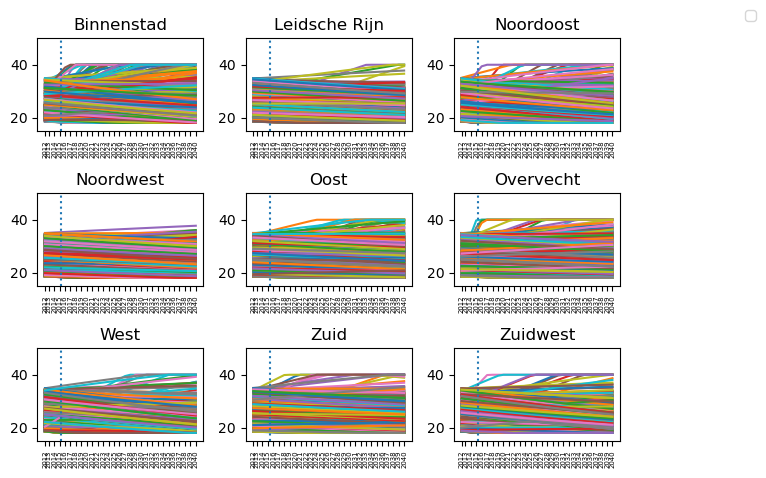

In [10]:
# Set information about taxes
n_timesteps, k4, p, buffer, filename = 84, 30, 0.2, 24, '20taxes'
agents_twentytaxes, twentytaxes = get_abm_model(n_timesteps, k4, p, filename)
display(twentytaxes)
get_plot(agents_twentytaxes)

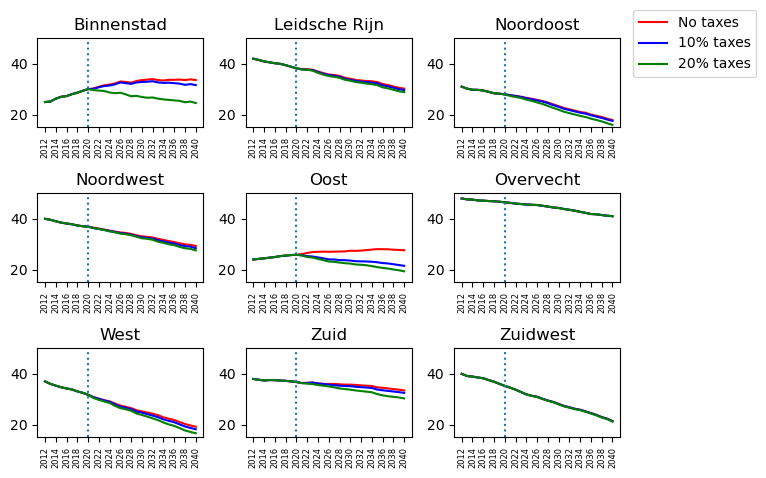

In [11]:
col_names = ['{}_over'.format(n) for n in range(n_timesteps) if (n+1)%3 == 0 or n == 0]
district = notaxes.district.unique()

N = len(district)
cols = 3
rows = int(math.ceil(N / cols))

x = [n for n in range(0, int(n_timesteps / 3) + 1, 2)]
labels = [2012 + n for n in x]

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure()

for idx, name in enumerate(district):
    ax = fig.add_subplot(gs[idx])
    nt = notaxes[notaxes.district == name][col_names].values[0]
    tt = tentaxes[notaxes.district == name][col_names].values[0]
    t2t = twentytaxes[notaxes.district == name][col_names].values[0]
    
    # Plotting both the curves simultaneously
    ax.plot(nt, color='r', label='No taxes')
    ax.plot(tt, color='b', label='10% taxes')
    ax.plot(t2t, color='g', label='20% taxes')
    ax.set_xticks(x, labels=labels, fontsize=6, rotation = 90)
    ax.axis(ymin=15, ymax=50)
    ax.set_title(name)
    ax.axvline(x = buffer/3, linestyle='dotted')
    

handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.2, 1))
fig.tight_layout()